# Sweep: Baseline at All Compression Ratios

Train baseline architecture at 5 compression ratios (4x, 8x, 16x, 32x, 64x)
to generate rate-distortion curves.

**Proven hyperparams:** LR=1e-4, AdamW, ReduceLROnPlateau, batch_size=32

**Monitor with TensorBoard:**
```bash
tensorboard --logdir=runs
```

## 1. Setup

In [1]:
import sys
import gc
import time
from pathlib import Path

project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import torch
from tqdm.auto import tqdm

from src.data.datamodule import SARDataModule
from src.models.autoencoder import SARAutoencoder
from src.losses.combined import CombinedLoss
from src.training.trainer import Trainer

print(f"Project root: {project_root}")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Project root: d:\Projects\CNNAutoencoderProject
PyTorch: 2.5.1+cu121
CUDA: True
GPU: NVIDIA GeForce RTX 3070
VRAM: 8.0 GB


## 2. Sweep Configuration

In [2]:
# ============================================================
# SWEEP CONFIGURATION
# ============================================================

# Data
DATA_PATH = "D:/Projects/CNNAutoencoderProject/data/patches/metadata.npy"
BATCH_SIZE = 36
NUM_WORKERS = 4
VAL_FRACTION = 0.1
TRAIN_SUBSET = 0.10  # Use 10% of data

# Fixed training params (proven with baseline@16x -> 20.47 dB)
EPOCHS = 35
LEARNING_RATE = 1e-4
EARLY_STOPPING_PATIENCE = 12
LR_PATIENCE = 10
LR_FACTOR = 0.5
MSE_WEIGHT = 0.5
SSIM_WEIGHT = 0.5
BASE_CHANNELS = 64

# Sweep variable: latent_channels -> compression ratio
# LC=64 -> 4x, LC=32 -> 8x, LC=21 -> ~12x
SWEEP_LATENT_CHANNELS = [64, 32, 21]

# ============================================================

print("Sweep Plan:")
print(f"  Model: baseline (BC={BASE_CHANNELS})")
print(f"  LR={LEARNING_RATE}, Epochs={EPOCHS}, Patience={EARLY_STOPPING_PATIENCE}")
print(f"  Data: {TRAIN_SUBSET*100:.0f}% subset, batch_size={BATCH_SIZE}")
print()
for lc in SWEEP_LATENT_CHANNELS:
    ratio = (256 * 256) / (16 * 16 * lc)
    name = f"baseline_c{lc}_b{BASE_CHANNELS}_cr{int(ratio)}x"
    print(f"  {name} ({ratio:.0f}x compression)")
print(f"\nTotal runs: {len(SWEEP_LATENT_CHANNELS)}")

Sweep Plan:
  Model: baseline (BC=64)
  LR=0.0001, Epochs=35, Patience=12
  Data: 10% subset, batch_size=36

  baseline_c64_b64_cr4x (4x compression)
  baseline_c32_b64_cr8x (8x compression)
  baseline_c21_b64_cr12x (12x compression)

Total runs: 3


## 3. Load Data (shared across all runs)

In [3]:
import random

print("Loading data...")
dm = SARDataModule(
    patches_path=DATA_PATH,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    val_fraction=VAL_FRACTION,
)

if TRAIN_SUBSET < 1.0:
    full_train_size = len(dm.train_dataset)
    train_subset_size = int(full_train_size * TRAIN_SUBSET)
    train_indices = random.sample(range(full_train_size), train_subset_size)
    dm.train_dataset = torch.utils.data.Subset(dm.train_dataset, train_indices)

    full_val_size = len(dm.val_dataset)
    val_subset_size = int(full_val_size * TRAIN_SUBSET)
    val_indices = random.sample(range(full_val_size), val_subset_size)
    dm.val_dataset = torch.utils.data.Subset(dm.val_dataset, val_indices)

    print(f"Using {TRAIN_SUBSET*100:.0f}% subset:")
    print(f"  Train: {train_subset_size:,} of {full_train_size:,}")
    print(f"  Val: {val_subset_size:,} of {full_val_size:,}")

print(f"\nPreprocessing params: {dm.preprocessing_params}")

Loading data...
Loading metadata from D:\Projects\CNNAutoencoderProject\data\patches\metadata.npy
Total patches: 696277
Train: 626650, Val: 69627
Using 10% subset:
  Train: 62,665 of 626,650
  Val: 6,962 of 69,627

Preprocessing params: {'vmin': np.float32(14.768799), 'vmax': np.float32(24.54073)}


## 4. Run Sweep

Each run trains baseline at one compression ratio. Progress tracked with tqdm, metrics logged to TensorBoard.

In [4]:
results = []

sweep_pbar = tqdm(SWEEP_LATENT_CHANNELS, desc="Sweep Progress", unit="run")

for lc in sweep_pbar:
    ratio = (256 * 256) / (16 * 16 * lc)
    run_name = f"baseline_c{lc}_b{BASE_CHANNELS}_cr{int(ratio)}x"
    sweep_pbar.set_postfix_str(f"{run_name}")

    print(f"\n{'=' * 70}")
    print(f"  {run_name} | LC={lc} | {ratio:.0f}x compression")
    print(f"{'=' * 70}")

    # Create model
    model = SARAutoencoder(
        latent_channels=lc,
        base_channels=BASE_CHANNELS,
    )
    params = model.count_parameters()
    print(f"  Parameters: {params['total']:,}")

    # Loss
    loss_fn = CombinedLoss(mse_weight=MSE_WEIGHT, ssim_weight=SSIM_WEIGHT)

    # Trainer config
    config = {
        'learning_rate': LEARNING_RATE,
        'optimizer': 'adamw',
        'scheduler': 'plateau',
        'lr_patience': LR_PATIENCE,
        'lr_factor': LR_FACTOR,
        'max_grad_norm': 1.0,
        'use_amp': True,
        'notebook': True,
        'run_name': run_name,
        'preprocessing_params': dm.preprocessing_params,
        'model_type': 'baseline',
        'latent_channels': lc,
        'base_channels': BASE_CHANNELS,
        'mse_weight': MSE_WEIGHT,
        'ssim_weight': SSIM_WEIGHT,
        'batch_size': BATCH_SIZE,
        'compression_ratio': ratio,
    }

    train_loader = dm.train_dataloader()
    val_loader = dm.val_dataloader()

    trainer = Trainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        loss_fn=loss_fn,
        config=config,
    )

    # Train
    t0 = time.time()
    history = trainer.train(
        epochs=EPOCHS,
        early_stopping_patience=EARLY_STOPPING_PATIENCE,
    )
    elapsed = time.time() - t0

    # Collect results
    result = {
        'run_name': trainer.run_name,
        'latent_channels': lc,
        'compression_ratio': ratio,
        'parameters': params['total'],
        'epochs_trained': len(history),
        'elapsed_min': elapsed / 60,
        'checkpoint': str(trainer.checkpoint_dir / 'best.pth'),
        'log_dir': str(trainer.log_dir),
    }

    if history:
        best_epoch = min(history, key=lambda h: h.get('val_loss', float('inf')))
        result['best_val_loss'] = best_epoch.get('val_loss')
        result['best_psnr'] = best_epoch.get('val_psnr')
        result['best_ssim'] = best_epoch.get('val_ssim')

    results.append(result)

    psnr_str = f"{result.get('best_psnr', 0):.2f} dB" if result.get('best_psnr') else "N/A"
    print(f"\n  Done: {psnr_str} | {elapsed/60:.1f} min | {trainer.checkpoint_dir / 'best.pth'}")

    # Cleanup GPU
    del model, trainer, loss_fn, train_loader, val_loader
    gc.collect()
    torch.cuda.empty_cache()

print("\nSweep complete!")

Sweep Progress:   0%|          | 0/3 [00:00<?, ?run/s]


  baseline_c64_b64_cr4x | LC=64 | 4x compression
  Parameters: 2,872,257
Using device: cuda
GPU memory: 1134MB / 8192MB (14% used, 6.9 GB free)


d:\Projects\CNNAutoencoderProject\venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
2026-01-27 19:53:55,434 - Log directory: runs\baseline_c64_b64_cr4x_20260127_195355
2026-01-27 19:53:55,435 - Checkpoint directory: checkpoints\baseline_c64_b64_cr4x_20260127_195355
2026-01-27 19:53:55,436 - Mixed Precision (AMP): enabled
2026-01-27 19:53:55,437 - Starting training for 35 epochs
2026-01-27 19:53:55,438 - Model: SARAutoencoder
2026-01-27 19:53:55,438 - Config: {'learning_rate': 0.0001, 'optimizer': 'adamw', 'scheduler': 'plateau', 'lr_patience': 10, 'lr_factor': 0.5, 'max_grad_norm': 1.0, 'use_amp': True, 'notebook': True, 'run_name': 'baseline_c64_b64_cr4x', 'preprocessing_params': {'vmin': np.float32(14.768799), 'vmax': np.float32(24.54073)}, 'model_type': 'baseline', 'latent_channels': 64, 'base_channels': 64, 'mse_weight': 0.5, 'ssim_weight': 0.5, 'batch_size'

Using AdamW optimizer with weight_decay=1e-05
Using ReduceLROnPlateau: patience=10
Mixed Precision (AMP) enabled - ~2x training speedup


Epoch 1 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 1 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 19:56:31,226 - New best model saved (val_loss: 0.1126) + archived to best_20260127_195631_epoch000_loss0.1126.pth
2026-01-27 19:56:31,429 - Epoch 1/35 | Train: loss=0.1452, psnr=20.49, ssim=0.7191 | Val: loss=0.1126, psnr=21.93, ssim=0.7813 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 2 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 2 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 19:58:21,994 - New best model saved (val_loss: 0.0962) + archived to best_20260127_195821_epoch001_loss0.0962.pth
2026-01-27 19:58:22,082 - Epoch 2/35 | Train: loss=0.1071, psnr=21.67, ssim=0.7927 | Val: loss=0.0962, psnr=22.18, ssim=0.8136 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 3 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 3 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 20:00:12,634 - New best model saved (val_loss: 0.0893) + archived to best_20260127_200012_epoch002_loss0.0893.pth
2026-01-27 20:00:12,721 - Epoch 3/35 | Train: loss=0.0967, psnr=22.12, ssim=0.8129 | Val: loss=0.0893, psnr=23.06, ssim=0.8264 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 4 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 4 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 20:02:02,849 - New best model saved (val_loss: 0.0858) + archived to best_20260127_200202_epoch003_loss0.0858.pth
2026-01-27 20:02:02,943 - Epoch 4/35 | Train: loss=0.0917, psnr=22.33, ssim=0.8226 | Val: loss=0.0858, psnr=22.58, ssim=0.8339 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 5 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 5 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 20:03:53,125 - New best model saved (val_loss: 0.0848) + archived to best_20260127_200353_epoch004_loss0.0848.pth
2026-01-27 20:03:53,209 - Epoch 5/35 | Train: loss=0.0885, psnr=22.49, ssim=0.8287 | Val: loss=0.0848, psnr=22.80, ssim=0.8357 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 6 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 6 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 20:05:43,820 - Epoch 6/35 | Train: loss=0.0871, psnr=22.60, ssim=0.8314 | Val: loss=0.0861, psnr=21.60, ssim=0.8348 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 7 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 7 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 20:07:35,094 - New best model saved (val_loss: 0.0799) + archived to best_20260127_200735_epoch006_loss0.0799.pth
2026-01-27 20:07:35,182 - Epoch 7/35 | Train: loss=0.0855, psnr=22.69, ssim=0.8345 | Val: loss=0.0799, psnr=23.57, ssim=0.8447 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 8 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 8 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 20:09:25,526 - Epoch 8/35 | Train: loss=0.0852, psnr=22.73, ssim=0.8349 | Val: loss=0.0856, psnr=22.42, ssim=0.8345 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 9 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 9 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 20:11:15,738 - New best model saved (val_loss: 0.0795) + archived to best_20260127_201115_epoch008_loss0.0795.pth
2026-01-27 20:11:15,828 - Epoch 9/35 | Train: loss=0.0833, psnr=22.91, ssim=0.8385 | Val: loss=0.0795, psnr=23.38, ssim=0.8456 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 10 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 10 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 20:13:06,536 - New best model saved (val_loss: 0.0778) + archived to best_20260127_201306_epoch009_loss0.0778.pth
2026-01-27 20:13:06,626 - Epoch 10/35 | Train: loss=0.0832, psnr=22.90, ssim=0.8388 | Val: loss=0.0778, psnr=23.69, ssim=0.8486 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 11 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 11 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 20:14:55,965 - Epoch 11/35 | Train: loss=0.0828, psnr=22.93, ssim=0.8396 | Val: loss=0.0801, psnr=22.23, ssim=0.8459 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 12 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 12 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 20:16:46,868 - Epoch 12/35 | Train: loss=0.0824, psnr=22.93, ssim=0.8403 | Val: loss=0.0787, psnr=23.20, ssim=0.8475 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 13 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 13 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 20:18:47,187 - New best model saved (val_loss: 0.0770) + archived to best_20260127_201847_epoch012_loss0.0770.pth
2026-01-27 20:18:47,283 - Epoch 13/35 | Train: loss=0.0820, psnr=22.96, ssim=0.8412 | Val: loss=0.0770, psnr=23.57, ssim=0.8504 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 14 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 14 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 20:20:34,736 - Epoch 14/35 | Train: loss=0.0815, psnr=23.01, ssim=0.8420 | Val: loss=0.0784, psnr=23.64, ssim=0.8475 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 15 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 15 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 20:22:22,313 - Epoch 15/35 | Train: loss=0.0812, psnr=22.99, ssim=0.8427 | Val: loss=0.0774, psnr=24.20, ssim=0.8491 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 16 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 16 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 20:24:07,144 - Epoch 16/35 | Train: loss=0.0809, psnr=23.04, ssim=0.8433 | Val: loss=0.0778, psnr=23.70, ssim=0.8486 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 17 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 17 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 20:25:58,543 - New best model saved (val_loss: 0.0766) + archived to best_20260127_202558_epoch016_loss0.0766.pth
2026-01-27 20:25:58,645 - Epoch 17/35 | Train: loss=0.0807, psnr=23.06, ssim=0.8436 | Val: loss=0.0766, psnr=23.42, ssim=0.8514 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 18 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 18 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 20:27:39,765 - New best model saved (val_loss: 0.0763) + archived to best_20260127_202739_epoch017_loss0.0763.pth
2026-01-27 20:27:39,855 - Epoch 18/35 | Train: loss=0.0801, psnr=23.12, ssim=0.8447 | Val: loss=0.0763, psnr=24.10, ssim=0.8514 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 19 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 19 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 20:29:25,623 - Epoch 19/35 | Train: loss=0.0795, psnr=23.15, ssim=0.8459 | Val: loss=0.0781, psnr=23.64, ssim=0.8481 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 20 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 20 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 20:31:11,403 - Epoch 20/35 | Train: loss=0.0790, psnr=23.20, ssim=0.8468 | Val: loss=0.0815, psnr=22.87, ssim=0.8422 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 21 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 21 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 20:32:57,627 - Epoch 21/35 | Train: loss=0.0796, psnr=23.18, ssim=0.8457 | Val: loss=0.0813, psnr=23.14, ssim=0.8423 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 22 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 22 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 20:34:43,117 - New best model saved (val_loss: 0.0762) + archived to best_20260127_203443_epoch021_loss0.0762.pth
2026-01-27 20:34:43,207 - Epoch 22/35 | Train: loss=0.0790, psnr=23.24, ssim=0.8468 | Val: loss=0.0762, psnr=23.14, ssim=0.8525 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 23 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 23 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 20:36:27,863 - Epoch 23/35 | Train: loss=0.0787, psnr=23.23, ssim=0.8474 | Val: loss=0.0765, psnr=23.57, ssim=0.8515 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 24 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 24 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 20:38:14,459 - Epoch 24/35 | Train: loss=0.0784, psnr=23.28, ssim=0.8479 | Val: loss=0.0822, psnr=23.47, ssim=0.8401 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 25 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 25 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 20:39:59,761 - New best model saved (val_loss: 0.0750) + archived to best_20260127_203959_epoch024_loss0.0750.pth
2026-01-27 20:39:59,853 - Epoch 25/35 | Train: loss=0.0783, psnr=23.26, ssim=0.8481 | Val: loss=0.0750, psnr=24.16, ssim=0.8538 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 26 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 26 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 20:41:45,668 - Epoch 26/35 | Train: loss=0.0787, psnr=23.22, ssim=0.8474 | Val: loss=0.0754, psnr=24.04, ssim=0.8532 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 27 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 27 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 20:43:29,296 - Epoch 27/35 | Train: loss=0.0780, psnr=23.25, ssim=0.8488 | Val: loss=0.0793, psnr=22.60, ssim=0.8469 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 28 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 28 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 20:45:14,979 - Epoch 28/35 | Train: loss=0.0782, psnr=23.31, ssim=0.8484 | Val: loss=0.0799, psnr=23.02, ssim=0.8453 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 29 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 29 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 20:46:58,489 - Epoch 29/35 | Train: loss=0.0774, psnr=23.36, ssim=0.8499 | Val: loss=0.0759, psnr=23.95, ssim=0.8523 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 30 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 30 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 20:48:44,096 - New best model saved (val_loss: 0.0743) + archived to best_20260127_204844_epoch029_loss0.0743.pth
2026-01-27 20:48:44,183 - Epoch 30/35 | Train: loss=0.0780, psnr=23.32, ssim=0.8487 | Val: loss=0.0743, psnr=24.15, ssim=0.8552 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 31 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 31 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 20:50:29,267 - Epoch 31/35 | Train: loss=0.0777, psnr=23.30, ssim=0.8493 | Val: loss=0.0748, psnr=24.13, ssim=0.8543 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 32 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 32 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 20:52:15,462 - Epoch 32/35 | Train: loss=0.0774, psnr=23.33, ssim=0.8500 | Val: loss=0.0819, psnr=23.03, ssim=0.8411 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 33 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 33 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 20:54:01,827 - Epoch 33/35 | Train: loss=0.0778, psnr=23.29, ssim=0.8493 | Val: loss=0.0769, psnr=23.90, ssim=0.8504 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 34 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 34 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 20:55:48,629 - Epoch 34/35 | Train: loss=0.0773, psnr=23.35, ssim=0.8502 | Val: loss=0.0844, psnr=20.70, ssim=0.8397 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 35 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 35 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 20:57:35,405 - Epoch 35/35 | Train: loss=0.0774, psnr=23.35, ssim=0.8499 | Val: loss=0.0763, psnr=24.35, ssim=0.8510 | LR: 1.00e-04 | GPU: 0.04GB
2026-01-27 20:57:35,405 - Training complete. Best val loss: 0.0743



  Done: 24.15 dB | 63.7 min | checkpoints\baseline_c64_b64_cr4x_20260127_195355\best.pth


2026-01-27 20:57:41,220 - Log directory: runs\baseline_c32_b64_cr8x_20260127_205741
2026-01-27 20:57:41,221 - Checkpoint directory: checkpoints\baseline_c32_b64_cr8x_20260127_205741
2026-01-27 20:57:41,222 - Mixed Precision (AMP): enabled
2026-01-27 20:57:41,222 - Starting training for 35 epochs
2026-01-27 20:57:41,223 - Model: SARAutoencoder
2026-01-27 20:57:41,224 - Config: {'learning_rate': 0.0001, 'optimizer': 'adamw', 'scheduler': 'plateau', 'lr_patience': 10, 'lr_factor': 0.5, 'max_grad_norm': 1.0, 'use_amp': True, 'notebook': True, 'run_name': 'baseline_c32_b64_cr8x', 'preprocessing_params': {'vmin': np.float32(14.768799), 'vmax': np.float32(24.54073)}, 'model_type': 'baseline', 'latent_channels': 32, 'base_channels': 64, 'mse_weight': 0.5, 'ssim_weight': 0.5, 'batch_size': 36, 'compression_ratio': 8.0}



  baseline_c32_b64_cr8x | LC=32 | 8x compression
  Parameters: 2,462,625
Using device: cuda
GPU memory: 1323MB / 8192MB (16% used, 6.7 GB free)
Using AdamW optimizer with weight_decay=1e-05
Using ReduceLROnPlateau: patience=10
Mixed Precision (AMP) enabled - ~2x training speedup


Epoch 1 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 1 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 21:00:07,571 - New best model saved (val_loss: 0.1917) + archived to best_20260127_210007_epoch000_loss0.1917.pth
2026-01-27 21:00:07,681 - Epoch 1/35 | Train: loss=0.2043, psnr=19.24, ssim=0.6038 | Val: loss=0.1917, psnr=20.36, ssim=0.6259 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 2 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 2 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 21:01:49,870 - New best model saved (val_loss: 0.1802) + archived to best_20260127_210149_epoch001_loss0.1802.pth
2026-01-27 21:01:49,960 - Epoch 2/35 | Train: loss=0.1811, psnr=20.01, ssim=0.6478 | Val: loss=0.1802, psnr=19.63, ssim=0.6505 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 3 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 3 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 21:03:32,073 - New best model saved (val_loss: 0.1765) + archived to best_20260127_210332_epoch002_loss0.1765.pth
2026-01-27 21:03:32,165 - Epoch 3/35 | Train: loss=0.1773, psnr=20.19, ssim=0.6550 | Val: loss=0.1765, psnr=20.19, ssim=0.6567 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 4 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 4 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 21:05:21,987 - New best model saved (val_loss: 0.1746) + archived to best_20260127_210521_epoch003_loss0.1746.pth
2026-01-27 21:05:22,085 - Epoch 4/35 | Train: loss=0.1757, psnr=20.27, ssim=0.6581 | Val: loss=0.1746, psnr=20.96, ssim=0.6588 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 5 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 5 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 21:07:12,128 - Epoch 5/35 | Train: loss=0.1744, psnr=20.36, ssim=0.6604 | Val: loss=0.1783, psnr=20.36, ssim=0.6526 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 6 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 6 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 21:09:05,578 - Epoch 6/35 | Train: loss=0.1736, psnr=20.38, ssim=0.6620 | Val: loss=0.1747, psnr=20.82, ssim=0.6589 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 7 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 7 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 21:10:53,257 - Epoch 7/35 | Train: loss=0.1726, psnr=20.45, ssim=0.6639 | Val: loss=0.1753, psnr=20.48, ssim=0.6584 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 8 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 8 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 21:12:39,002 - New best model saved (val_loss: 0.1741) + archived to best_20260127_211238_epoch007_loss0.1741.pth
2026-01-27 21:12:39,094 - Epoch 8/35 | Train: loss=0.1717, psnr=20.50, ssim=0.6655 | Val: loss=0.1741, psnr=20.88, ssim=0.6599 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 9 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 9 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 21:14:22,528 - Epoch 9/35 | Train: loss=0.1713, psnr=20.49, ssim=0.6664 | Val: loss=0.1759, psnr=20.82, ssim=0.6565 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 10 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 10 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 21:16:01,447 - New best model saved (val_loss: 0.1739) + archived to best_20260127_211601_epoch009_loss0.1739.pth
2026-01-27 21:16:01,542 - Epoch 10/35 | Train: loss=0.1709, psnr=20.52, ssim=0.6672 | Val: loss=0.1739, psnr=20.58, ssim=0.6610 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 11 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 11 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 21:17:53,884 - New best model saved (val_loss: 0.1709) + archived to best_20260127_211753_epoch010_loss0.1709.pth
2026-01-27 21:17:53,988 - Epoch 11/35 | Train: loss=0.1708, psnr=20.51, ssim=0.6674 | Val: loss=0.1709, psnr=20.90, ssim=0.6662 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 12 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 12 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 21:19:41,945 - New best model saved (val_loss: 0.1704) + archived to best_20260127_211941_epoch011_loss0.1704.pth
2026-01-27 21:19:42,046 - Epoch 12/35 | Train: loss=0.1703, psnr=20.54, ssim=0.6683 | Val: loss=0.1704, psnr=21.18, ssim=0.6668 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 13 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 13 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 21:21:28,667 - Epoch 13/35 | Train: loss=0.1702, psnr=20.53, ssim=0.6684 | Val: loss=0.1709, psnr=20.89, ssim=0.6663 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 14 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 14 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 21:23:13,694 - New best model saved (val_loss: 0.1693) + archived to best_20260127_212313_epoch013_loss0.1693.pth
2026-01-27 21:23:13,789 - Epoch 14/35 | Train: loss=0.1696, psnr=20.56, ssim=0.6696 | Val: loss=0.1693, psnr=21.11, ssim=0.6691 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 15 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 15 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 21:25:02,612 - Epoch 15/35 | Train: loss=0.1690, psnr=20.59, ssim=0.6707 | Val: loss=0.1729, psnr=20.75, ssim=0.6627 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 16 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 16 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 21:26:50,781 - Epoch 16/35 | Train: loss=0.1693, psnr=20.57, ssim=0.6703 | Val: loss=0.1718, psnr=20.72, ssim=0.6649 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 17 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 17 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 21:28:37,555 - New best model saved (val_loss: 0.1685) + archived to best_20260127_212837_epoch016_loss0.1685.pth
2026-01-27 21:28:37,664 - Epoch 17/35 | Train: loss=0.1683, psnr=20.63, ssim=0.6721 | Val: loss=0.1685, psnr=21.21, ssim=0.6705 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 18 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 18 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 21:30:22,337 - Epoch 18/35 | Train: loss=0.1683, psnr=20.60, ssim=0.6722 | Val: loss=0.1688, psnr=21.18, ssim=0.6700 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 19 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 19 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 21:32:07,670 - Epoch 19/35 | Train: loss=0.1683, psnr=20.60, ssim=0.6723 | Val: loss=0.1701, psnr=20.93, ssim=0.6679 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 20 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 20 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 21:33:52,310 - New best model saved (val_loss: 0.1678) + archived to best_20260127_213352_epoch019_loss0.1678.pth
2026-01-27 21:33:52,406 - Epoch 20/35 | Train: loss=0.1672, psnr=20.65, ssim=0.6742 | Val: loss=0.1678, psnr=21.34, ssim=0.6716 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 21 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 21 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 21:35:37,879 - Epoch 21/35 | Train: loss=0.1678, psnr=20.63, ssim=0.6730 | Val: loss=0.1682, psnr=21.04, ssim=0.6715 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 22 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 22 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 21:37:22,322 - Epoch 22/35 | Train: loss=0.1679, psnr=20.60, ssim=0.6730 | Val: loss=0.1721, psnr=19.75, ssim=0.6663 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 23 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 23 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 21:39:06,688 - Epoch 23/35 | Train: loss=0.1672, psnr=20.65, ssim=0.6743 | Val: loss=0.1737, psnr=20.70, ssim=0.6611 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 24 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 24 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 21:40:51,862 - New best model saved (val_loss: 0.1676) + archived to best_20260127_214051_epoch023_loss0.1676.pth
2026-01-27 21:40:51,953 - Epoch 24/35 | Train: loss=0.1675, psnr=20.63, ssim=0.6736 | Val: loss=0.1676, psnr=21.21, ssim=0.6724 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 25 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 25 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 21:42:35,387 - Epoch 25/35 | Train: loss=0.1672, psnr=20.65, ssim=0.6743 | Val: loss=0.1752, psnr=21.52, ssim=0.6566 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 26 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 26 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 21:44:18,816 - New best model saved (val_loss: 0.1672) + archived to best_20260127_214418_epoch025_loss0.1672.pth
2026-01-27 21:44:18,911 - Epoch 26/35 | Train: loss=0.1668, psnr=20.67, ssim=0.6750 | Val: loss=0.1672, psnr=21.33, ssim=0.6731 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 27 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 27 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 21:46:02,609 - Epoch 27/35 | Train: loss=0.1664, psnr=20.68, ssim=0.6759 | Val: loss=0.1686, psnr=21.06, ssim=0.6705 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 28 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 28 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 21:47:46,657 - New best model saved (val_loss: 0.1670) + archived to best_20260127_214746_epoch027_loss0.1670.pth
2026-01-27 21:47:46,767 - Epoch 28/35 | Train: loss=0.1667, psnr=20.63, ssim=0.6753 | Val: loss=0.1670, psnr=21.13, ssim=0.6738 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 29 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 29 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 21:49:33,740 - Epoch 29/35 | Train: loss=0.1669, psnr=20.62, ssim=0.6750 | Val: loss=0.1696, psnr=21.16, ssim=0.6685 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 30 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 30 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 21:51:16,943 - Epoch 30/35 | Train: loss=0.1668, psnr=20.62, ssim=0.6751 | Val: loss=0.1671, psnr=21.40, ssim=0.6730 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 31 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 31 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 21:53:00,569 - Epoch 31/35 | Train: loss=0.1665, psnr=20.65, ssim=0.6757 | Val: loss=0.1673, psnr=21.00, ssim=0.6734 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 32 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 32 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 21:54:43,920 - Epoch 32/35 | Train: loss=0.1667, psnr=20.62, ssim=0.6753 | Val: loss=0.1687, psnr=21.17, ssim=0.6702 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 33 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 33 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 21:56:27,509 - Epoch 33/35 | Train: loss=0.1661, psnr=20.68, ssim=0.6764 | Val: loss=0.1680, psnr=21.19, ssim=0.6717 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 34 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 34 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 21:58:11,519 - New best model saved (val_loss: 0.1669) + archived to best_20260127_215811_epoch033_loss0.1669.pth
2026-01-27 21:58:11,611 - Epoch 34/35 | Train: loss=0.1659, psnr=20.70, ssim=0.6767 | Val: loss=0.1669, psnr=21.29, ssim=0.6737 | LR: 1.00e-04 | GPU: 0.04GB


Epoch 35 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 35 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 21:59:54,856 - New best model saved (val_loss: 0.1662) + archived to best_20260127_215954_epoch034_loss0.1662.pth
2026-01-27 21:59:54,944 - Epoch 35/35 | Train: loss=0.1657, psnr=20.70, ssim=0.6772 | Val: loss=0.1662, psnr=21.34, ssim=0.6749 | LR: 1.00e-04 | GPU: 0.04GB
2026-01-27 21:59:54,945 - Training complete. Best val loss: 0.1662



  Done: 21.34 dB | 62.2 min | checkpoints\baseline_c32_b64_cr8x_20260127_205741\best.pth


2026-01-27 22:00:01,420 - Log directory: runs\baseline_c21_b64_cr12x_20260127_220001
2026-01-27 22:00:01,422 - Checkpoint directory: checkpoints\baseline_c21_b64_cr12x_20260127_220001
2026-01-27 22:00:01,422 - Mixed Precision (AMP): enabled
2026-01-27 22:00:01,422 - Starting training for 35 epochs
2026-01-27 22:00:01,423 - Model: SARAutoencoder
2026-01-27 22:00:01,423 - Config: {'learning_rate': 0.0001, 'optimizer': 'adamw', 'scheduler': 'plateau', 'lr_patience': 10, 'lr_factor': 0.5, 'max_grad_norm': 1.0, 'use_amp': True, 'notebook': True, 'run_name': 'baseline_c21_b64_cr12x', 'preprocessing_params': {'vmin': np.float32(14.768799), 'vmax': np.float32(24.54073)}, 'model_type': 'baseline', 'latent_channels': 21, 'base_channels': 64, 'mse_weight': 0.5, 'ssim_weight': 0.5, 'batch_size': 36, 'compression_ratio': 12.19047619047619}



  baseline_c21_b64_cr12x | LC=21 | 12x compression
  Parameters: 2,321,814
Using device: cuda
GPU memory: 1473MB / 8192MB (18% used, 6.6 GB free)
Using AdamW optimizer with weight_decay=1e-05
Using ReduceLROnPlateau: patience=10
Mixed Precision (AMP) enabled - ~2x training speedup


Epoch 1 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 1 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 22:02:25,321 - New best model saved (val_loss: 0.2385) + archived to best_20260127_220225_epoch000_loss0.2385.pth
2026-01-27 22:02:25,486 - Epoch 1/35 | Train: loss=0.2543, psnr=18.23, ssim=0.5068 | Val: loss=0.2385, psnr=19.11, ssim=0.5354 | LR: 1.00e-04 | GPU: 0.03GB


Epoch 2 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 2 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 22:04:11,339 - New best model saved (val_loss: 0.2378) + archived to best_20260127_220411_epoch001_loss0.2378.pth
2026-01-27 22:04:11,449 - Epoch 2/35 | Train: loss=0.2378, psnr=18.80, ssim=0.5377 | Val: loss=0.2378, psnr=19.25, ssim=0.5363 | LR: 1.00e-04 | GPU: 0.03GB


Epoch 3 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 3 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 22:06:01,710 - New best model saved (val_loss: 0.2347) + archived to best_20260127_220601_epoch002_loss0.2347.pth
2026-01-27 22:06:01,806 - Epoch 3/35 | Train: loss=0.2350, psnr=18.96, ssim=0.5427 | Val: loss=0.2347, psnr=19.44, ssim=0.5419 | LR: 1.00e-04 | GPU: 0.03GB


Epoch 4 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 4 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 22:07:52,351 - Epoch 4/35 | Train: loss=0.2332, psnr=19.07, ssim=0.5460 | Val: loss=0.2350, psnr=19.66, ssim=0.5408 | LR: 1.00e-04 | GPU: 0.03GB


Epoch 5 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 5 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 22:09:42,159 - New best model saved (val_loss: 0.2343) + archived to best_20260127_220942_epoch004_loss0.2343.pth
2026-01-27 22:09:42,272 - Epoch 5/35 | Train: loss=0.2326, psnr=19.10, ssim=0.5471 | Val: loss=0.2343, psnr=19.62, ssim=0.5424 | LR: 1.00e-04 | GPU: 0.03GB


Epoch 6 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 6 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 22:11:27,305 - Epoch 6/35 | Train: loss=0.2313, psnr=19.16, ssim=0.5496 | Val: loss=0.2365, psnr=19.37, ssim=0.5386 | LR: 1.00e-04 | GPU: 0.03GB


Epoch 7 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 7 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 22:13:09,931 - Epoch 7/35 | Train: loss=0.2309, psnr=19.20, ssim=0.5502 | Val: loss=0.2356, psnr=19.64, ssim=0.5397 | LR: 1.00e-04 | GPU: 0.03GB


Epoch 8 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 8 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 22:14:52,670 - Epoch 8/35 | Train: loss=0.2307, psnr=19.20, ssim=0.5506 | Val: loss=0.2387, psnr=19.08, ssim=0.5349 | LR: 1.00e-04 | GPU: 0.03GB


Epoch 9 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 9 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 22:16:35,803 - Epoch 9/35 | Train: loss=0.2296, psnr=19.25, ssim=0.5527 | Val: loss=0.2360, psnr=19.39, ssim=0.5394 | LR: 1.00e-04 | GPU: 0.03GB


Epoch 10 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 10 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 22:18:18,436 - New best model saved (val_loss: 0.2327) + archived to best_20260127_221818_epoch009_loss0.2327.pth
2026-01-27 22:18:18,527 - Epoch 10/35 | Train: loss=0.2293, psnr=19.26, ssim=0.5534 | Val: loss=0.2327, psnr=19.41, ssim=0.5462 | LR: 1.00e-04 | GPU: 0.03GB


Epoch 11 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 11 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 22:20:01,566 - New best model saved (val_loss: 0.2312) + archived to best_20260127_222001_epoch010_loss0.2312.pth
2026-01-27 22:20:01,661 - Epoch 11/35 | Train: loss=0.2285, psnr=19.28, ssim=0.5548 | Val: loss=0.2312, psnr=19.77, ssim=0.5481 | LR: 1.00e-04 | GPU: 0.03GB


Epoch 12 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 12 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 22:21:44,299 - New best model saved (val_loss: 0.2308) + archived to best_20260127_222144_epoch011_loss0.2308.pth
2026-01-27 22:21:44,388 - Epoch 12/35 | Train: loss=0.2285, psnr=19.28, ssim=0.5548 | Val: loss=0.2308, psnr=19.49, ssim=0.5496 | LR: 1.00e-04 | GPU: 0.03GB


Epoch 13 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 13 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 22:23:27,356 - Epoch 13/35 | Train: loss=0.2278, psnr=19.30, ssim=0.5562 | Val: loss=0.2321, psnr=19.01, ssim=0.5484 | LR: 1.00e-04 | GPU: 0.03GB


Epoch 14 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 14 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 22:25:10,338 - Epoch 14/35 | Train: loss=0.2272, psnr=19.32, ssim=0.5574 | Val: loss=0.2335, psnr=19.44, ssim=0.5444 | LR: 1.00e-04 | GPU: 0.03GB


Epoch 15 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 15 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 22:26:52,948 - New best model saved (val_loss: 0.2300) + archived to best_20260127_222652_epoch014_loss0.2300.pth
2026-01-27 22:26:53,052 - Epoch 15/35 | Train: loss=0.2269, psnr=19.33, ssim=0.5580 | Val: loss=0.2300, psnr=19.43, ssim=0.5514 | LR: 1.00e-04 | GPU: 0.03GB


Epoch 16 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 16 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 22:28:35,850 - New best model saved (val_loss: 0.2297) + archived to best_20260127_222835_epoch015_loss0.2297.pth
2026-01-27 22:28:35,939 - Epoch 16/35 | Train: loss=0.2266, psnr=19.32, ssim=0.5585 | Val: loss=0.2297, psnr=19.59, ssim=0.5515 | LR: 1.00e-04 | GPU: 0.03GB


Epoch 17 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 17 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 22:30:18,521 - New best model saved (val_loss: 0.2280) + archived to best_20260127_223018_epoch016_loss0.2280.pth
2026-01-27 22:30:18,610 - Epoch 17/35 | Train: loss=0.2260, psnr=19.35, ssim=0.5596 | Val: loss=0.2280, psnr=19.83, ssim=0.5544 | LR: 1.00e-04 | GPU: 0.03GB


Epoch 18 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 18 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 22:32:01,575 - New best model saved (val_loss: 0.2277) + archived to best_20260127_223201_epoch017_loss0.2277.pth
2026-01-27 22:32:01,665 - Epoch 18/35 | Train: loss=0.2255, psnr=19.35, ssim=0.5606 | Val: loss=0.2277, psnr=19.77, ssim=0.5552 | LR: 1.00e-04 | GPU: 0.03GB


Epoch 19 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 19 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 22:33:44,638 - Epoch 19/35 | Train: loss=0.2247, psnr=19.37, ssim=0.5623 | Val: loss=0.2284, psnr=19.57, ssim=0.5542 | LR: 1.00e-04 | GPU: 0.03GB


Epoch 20 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 20 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 22:35:27,310 - New best model saved (val_loss: 0.2268) + archived to best_20260127_223527_epoch019_loss0.2268.pth
2026-01-27 22:35:27,399 - Epoch 20/35 | Train: loss=0.2243, psnr=19.36, ssim=0.5631 | Val: loss=0.2268, psnr=19.46, ssim=0.5577 | LR: 1.00e-04 | GPU: 0.03GB


Epoch 21 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 21 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 22:37:10,276 - New best model saved (val_loss: 0.2252) + archived to best_20260127_223710_epoch020_loss0.2252.pth
2026-01-27 22:37:10,380 - Epoch 21/35 | Train: loss=0.2231, psnr=19.37, ssim=0.5654 | Val: loss=0.2252, psnr=19.51, ssim=0.5607 | LR: 1.00e-04 | GPU: 0.03GB


Epoch 22 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 22 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 22:38:53,010 - New best model saved (val_loss: 0.2236) + archived to best_20260127_223852_epoch021_loss0.2236.pth
2026-01-27 22:38:53,094 - Epoch 22/35 | Train: loss=0.2225, psnr=19.35, ssim=0.5666 | Val: loss=0.2236, psnr=19.80, ssim=0.5632 | LR: 1.00e-04 | GPU: 0.03GB


Epoch 23 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 23 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 22:40:36,064 - New best model saved (val_loss: 0.2227) + archived to best_20260127_224036_epoch022_loss0.2227.pth
2026-01-27 22:40:36,152 - Epoch 23/35 | Train: loss=0.2214, psnr=19.36, ssim=0.5688 | Val: loss=0.2227, psnr=19.80, ssim=0.5650 | LR: 1.00e-04 | GPU: 0.03GB


Epoch 24 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 24 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 22:42:19,188 - Epoch 24/35 | Train: loss=0.2205, psnr=19.36, ssim=0.5707 | Val: loss=0.2231, psnr=19.85, ssim=0.5642 | LR: 1.00e-04 | GPU: 0.03GB


Epoch 25 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 25 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 22:44:01,787 - New best model saved (val_loss: 0.2219) + archived to best_20260127_224401_epoch024_loss0.2219.pth
2026-01-27 22:44:01,887 - Epoch 25/35 | Train: loss=0.2197, psnr=19.37, ssim=0.5722 | Val: loss=0.2219, psnr=19.66, ssim=0.5670 | LR: 1.00e-04 | GPU: 0.03GB


Epoch 26 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 26 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 22:45:44,735 - Epoch 26/35 | Train: loss=0.2192, psnr=19.36, ssim=0.5732 | Val: loss=0.2222, psnr=19.81, ssim=0.5660 | LR: 1.00e-04 | GPU: 0.03GB


Epoch 27 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 27 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 22:47:27,312 - New best model saved (val_loss: 0.2192) + archived to best_20260127_224727_epoch026_loss0.2192.pth
2026-01-27 22:47:27,414 - Epoch 27/35 | Train: loss=0.2182, psnr=19.39, ssim=0.5751 | Val: loss=0.2192, psnr=19.78, ssim=0.5721 | LR: 1.00e-04 | GPU: 0.03GB


Epoch 28 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 28 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 22:49:10,429 - Epoch 28/35 | Train: loss=0.2178, psnr=19.36, ssim=0.5761 | Val: loss=0.2195, psnr=19.53, ssim=0.5722 | LR: 1.00e-04 | GPU: 0.03GB


Epoch 29 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 29 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 22:50:53,469 - New best model saved (val_loss: 0.2178) + archived to best_20260127_225053_epoch028_loss0.2178.pth
2026-01-27 22:50:53,557 - Epoch 29/35 | Train: loss=0.2169, psnr=19.39, ssim=0.5778 | Val: loss=0.2178, psnr=19.64, ssim=0.5752 | LR: 1.00e-04 | GPU: 0.03GB


Epoch 30 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 30 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 22:52:36,174 - New best model saved (val_loss: 0.2170) + archived to best_20260127_225236_epoch029_loss0.2170.pth
2026-01-27 22:52:36,263 - Epoch 30/35 | Train: loss=0.2165, psnr=19.37, ssim=0.5787 | Val: loss=0.2170, psnr=19.55, ssim=0.5771 | LR: 1.00e-04 | GPU: 0.03GB


Epoch 31 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 31 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 22:54:19,291 - New best model saved (val_loss: 0.2156) + archived to best_20260127_225419_epoch030_loss0.2156.pth
2026-01-27 22:54:19,391 - Epoch 31/35 | Train: loss=0.2160, psnr=19.35, ssim=0.5798 | Val: loss=0.2156, psnr=19.80, ssim=0.5793 | LR: 1.00e-04 | GPU: 0.03GB


Epoch 32 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 32 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 22:56:02,028 - New best model saved (val_loss: 0.2144) + archived to best_20260127_225601_epoch031_loss0.2144.pth
2026-01-27 22:56:02,121 - Epoch 32/35 | Train: loss=0.2149, psnr=19.38, ssim=0.5817 | Val: loss=0.2144, psnr=19.90, ssim=0.5814 | LR: 1.00e-04 | GPU: 0.03GB


Epoch 33 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 33 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 22:57:45,055 - New best model saved (val_loss: 0.2126) + archived to best_20260127_225745_epoch032_loss0.2126.pth
2026-01-27 22:57:45,157 - Epoch 33/35 | Train: loss=0.2140, psnr=19.34, ssim=0.5837 | Val: loss=0.2126, psnr=19.81, ssim=0.5853 | LR: 1.00e-04 | GPU: 0.03GB


Epoch 34 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 34 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 22:59:28,318 - Epoch 34/35 | Train: loss=0.2120, psnr=19.36, ssim=0.5876 | Val: loss=0.2135, psnr=19.63, ssim=0.5838 | LR: 1.00e-04 | GPU: 0.03GB


Epoch 35 [Train]:   0%|          | 0/1740 [00:00<?, ?it/s]

Epoch 35 [Val]:   0%|          | 0/194 [00:00<?, ?it/s]

2026-01-27 23:01:12,701 - New best model saved (val_loss: 0.2082) + archived to best_20260127_230112_epoch034_loss0.2082.pth
2026-01-27 23:01:12,810 - Epoch 35/35 | Train: loss=0.2104, psnr=19.34, ssim=0.5910 | Val: loss=0.2082, psnr=19.48, ssim=0.5948 | LR: 1.00e-04 | GPU: 0.03GB
2026-01-27 23:01:12,811 - Training complete. Best val loss: 0.2082



  Done: 19.48 dB | 61.2 min | checkpoints\baseline_c21_b64_cr12x_20260127_220001\best.pth

Sweep complete!


## 5. Results Summary

In [8]:
print(f"{'Run':<40} {'Ratio':>6} {'PSNR':>10} {'SSIM':>10} {'Epochs':>8} {'Time':>8}")
print("-" * 84)

for r in results:
    name = r['run_name']
    ratio = f"{r['compression_ratio']:.0f}x"
    psnr = f"{r['best_psnr']:.2f} dB" if r.get('best_psnr') else "N/A"
    ssim = f"{r['best_ssim']:.4f}" if r.get('best_ssim') else "N/A"
    epochs = str(r['epochs_trained'])
    mins = f"{r['elapsed_min']:.0f}m"
    print(f"{name:<40} {ratio:>6} {psnr:>10} {ssim:>10} {epochs:>8} {mins:>8}")

Run                                       Ratio       PSNR       SSIM   Epochs     Time
------------------------------------------------------------------------------------
baseline_c64_b64_cr4x_20260127_195355        4x   24.15 dB     0.8552       35      64m
baseline_c32_b64_cr8x_20260127_205741        8x   21.34 dB     0.6749       35      62m
baseline_c21_b64_cr12x_20260127_220001      12x   19.48 dB     0.5948       35      61m


## 6. Rate-Distortion Curve

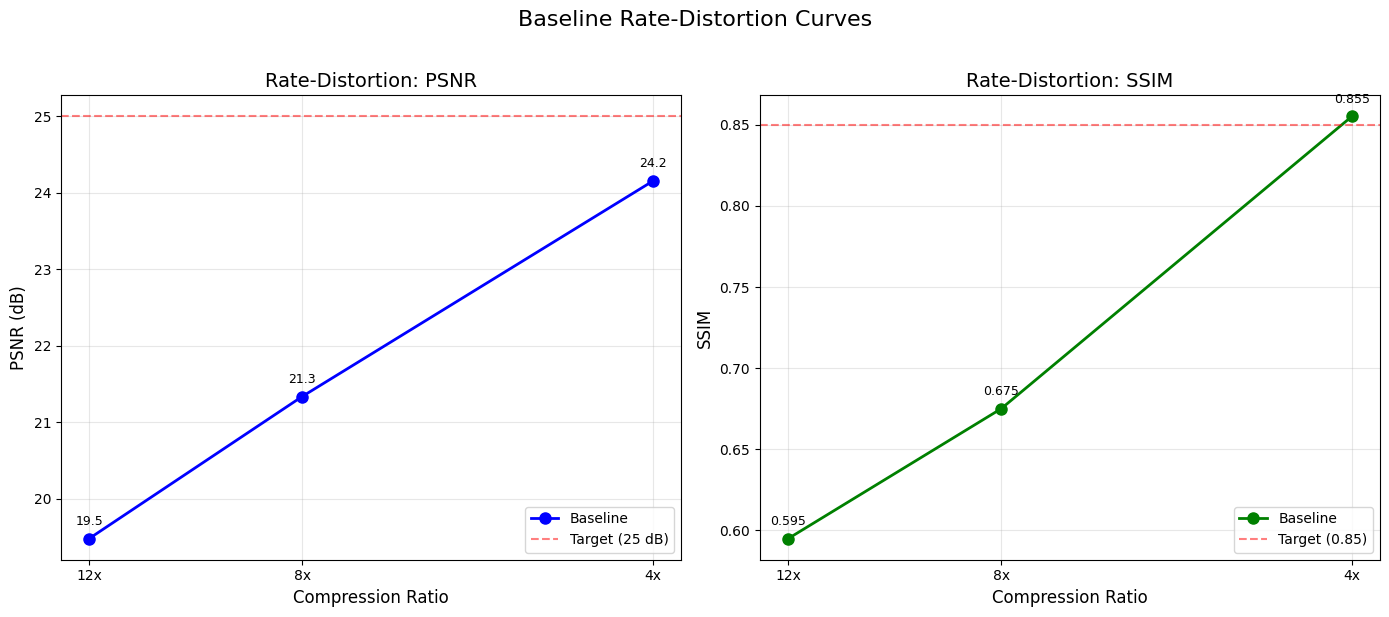

Saved to: runs/baseline_rate_distortion_20260127.png


In [9]:
import matplotlib.pyplot as plt
from datetime import datetime

# Extract data for plotting
ratios = [r['compression_ratio'] for r in results if r.get('best_psnr')]
psnrs = [r['best_psnr'] for r in results if r.get('best_psnr')]
ssims = [r['best_ssim'] for r in results if r.get('best_ssim')]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# PSNR vs Compression Ratio
ax1.plot(ratios, psnrs, 'bo-', markersize=8, linewidth=2, label='Baseline')
for r, p in zip(ratios, psnrs):
    ax1.annotate(f'{p:.1f}', (r, p), textcoords='offset points',
                 xytext=(0, 10), ha='center', fontsize=9)
ax1.axhline(y=25, color='r', linestyle='--', alpha=0.5, label='Target (25 dB)')
ax1.set_xlabel('Compression Ratio', fontsize=12)
ax1.set_ylabel('PSNR (dB)', fontsize=12)
ax1.set_title('Rate-Distortion: PSNR', fontsize=14)
ax1.set_xscale('log', base=2)
ax1.set_xticks(ratios)
ax1.set_xticklabels([f'{int(r)}x' for r in ratios])
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.invert_xaxis()  # Higher compression = harder, show left-to-right easy->hard

# SSIM vs Compression Ratio
ax2.plot(ratios, ssims, 'go-', markersize=8, linewidth=2, label='Baseline')
for r, s in zip(ratios, ssims):
    ax2.annotate(f'{s:.3f}', (r, s), textcoords='offset points',
                 xytext=(0, 10), ha='center', fontsize=9)
ax2.axhline(y=0.85, color='r', linestyle='--', alpha=0.5, label='Target (0.85)')
ax2.set_xlabel('Compression Ratio', fontsize=12)
ax2.set_ylabel('SSIM', fontsize=12)
ax2.set_title('Rate-Distortion: SSIM', fontsize=14)
ax2.set_xscale('log', base=2)
ax2.set_xticks(ratios)
ax2.set_xticklabels([f'{int(r)}x' for r in ratios])
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.invert_xaxis()

plt.suptitle('Baseline Rate-Distortion Curves', fontsize=16, y=1.02)
plt.tight_layout()

datestamp = datetime.now().strftime('%Y%m%d')
save_path = f'runs/baseline_rate_distortion_{datestamp}.png'
plt.savefig(save_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved to: {save_path}")

## 7. Save Results to JSON

In [10]:
import json
from datetime import datetime

datestamp = datetime.now().strftime('%Y%m%d')

output = {
    'sweep_type': 'baseline_ratios',
    'timestamp': datetime.now().isoformat(),
    'config': {
        'model': 'baseline',
        'base_channels': BASE_CHANNELS,
        'learning_rate': LEARNING_RATE,
        'epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
        'train_subset': TRAIN_SUBSET,
    },
    'results': results,
}

output_path = Path(f'runs/sweep_baseline_ratios_{datestamp}.json')
with open(output_path, 'w') as f:
    json.dump(output, f, indent=2, default=str)

print(f"Results saved to: {output_path}")

Results saved to: runs\sweep_baseline_ratios_20260127.json


---

## Done!

**Next steps:**
1. View TensorBoard: `tensorboard --logdir=runs`
2. Run architecture sweep: `sweep_all_16x.ipynb`
3. Compare rate-distortion curves across architectures